# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


In [ ]:
# !wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
!ls

--2020-10-31 12:53:24--  http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86446976 (82M) [application/zip]
Saving to: ‘TP1-2-data.zip’

TP1-2-data.zip      100%[===================>]  82.44M  20.6MB/s    in 4.9s    

2020-10-31 12:53:30 (16.9 MB/s) - ‘TP1-2-data.zip’ saved [86446976/86446976]

Archive:  TP1-2-data.zip
   creating: data/
   creating: data/Scene/
   creating: data/Scene/PARoffice/
 extracting: data/Scene/PARoffice/image_0091.jpg  
 extracting: data/Scene/PARoffice/image_0167.jpg  
  inflating: data/Scene/PARoffice/image_0037.jpg  
 extracting: data/Scene/PARoffice/image_0135.jpg  
 extracting: data/Scene/PARoffice/image_0015.jpg  
 extracting: data/Scene/PARoffice/image_0182.jpg  
 extracting: data/Scene/PARoffice/image_0064.jpg  
 extracting: data/Scene/PARoffice/im

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
%run 'tools.py'
from os.path import join

data_path = "data"

# Partie 1 : SIFT

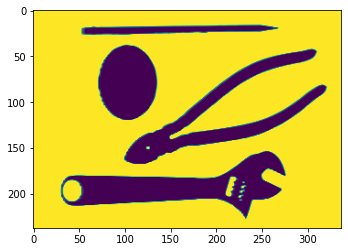

In [ ]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I)

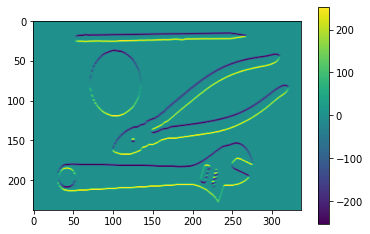

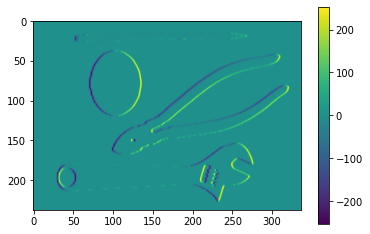

In [ ]:
def compute_grad(I):
    """
    calcule le gradient de l’image
    """
    ha = np.array([-1/4, 0, 1/4])
    hb = np.array([1, 2, 1])
    Ix = conv_separable(I, hb, ha) 
    Iy = conv_separable(I, ha, hb) 
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [ ]:
def compute_grad_mod_ori(I):
    """
    retourne le module Gn et l’orientation discrétisée Gdisc de l’image en entrée
    """
    Ix, Iy = compute_grad(I)
    Gn = np.sqrt(Ix**2+Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gn)
    return Gn, Go

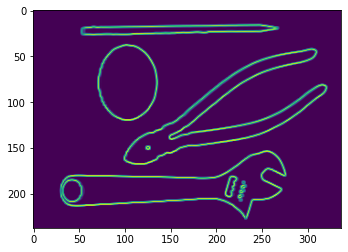

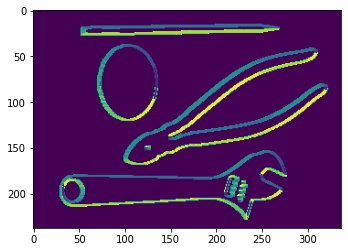

In [ ]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)
plt.show()
plt.imshow(Go)
plt.show()

In [ ]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))
    Gpond = g_n*gaussian_mask(size=4)
    for i in range(4):
        for j in range(4):
            hist[g_o[i,j]]+=Gpond[i,j]
    return hist
  

In [ ]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        Gn = Gn * mask
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

In [ ]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
#display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()
    #####################
    ## Votre code ici  ##
    #####################
    # Ici, effectuez les calculs sur l'image globale (norme, gradients)
    Gn, Go = compute_grad_mod_ori(im)

    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
      for j, yj in enumerate(y):
        sifts[i, j, :] = compute_sift_region(Gn[xi:xi+16, yj:yj+16], Go[xi:xi+16, yj:yj+16],  m)
      
    return sifts

# Compute SIFT

Le calcul durera plusieurs minutes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
max_images_per_class = 10  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


# Partie 2 : Dictionnaire visuel

In [ ]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [ ]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init,verbose=verbose).fit(sift)
    centers=kmeans.cluster_centers_
    labels=kmeans.labels_
    vdict = np.append((centers, np.zeros(128).reshape(-1,1)),axis=0)
    return vdict


In [ ]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


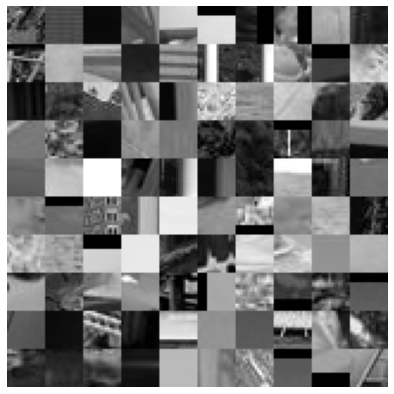

In [ ]:
# Study of the dict

# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

vdregions=np.empty([1001,16,16])
for c in range (np.shape(vdict)[0]) :
  regions={}
  for i in range (len(sifts)):
    d=((vdict[c]-sifts[i])**2).sum()
    regions[i]=d
  regions={k: v for k, v in sorted(regions.items(), key=lambda item: item[1])}
  topregions=list(regions.keys())[0:50]
  vdregions[c] = regions[topregions[0]]


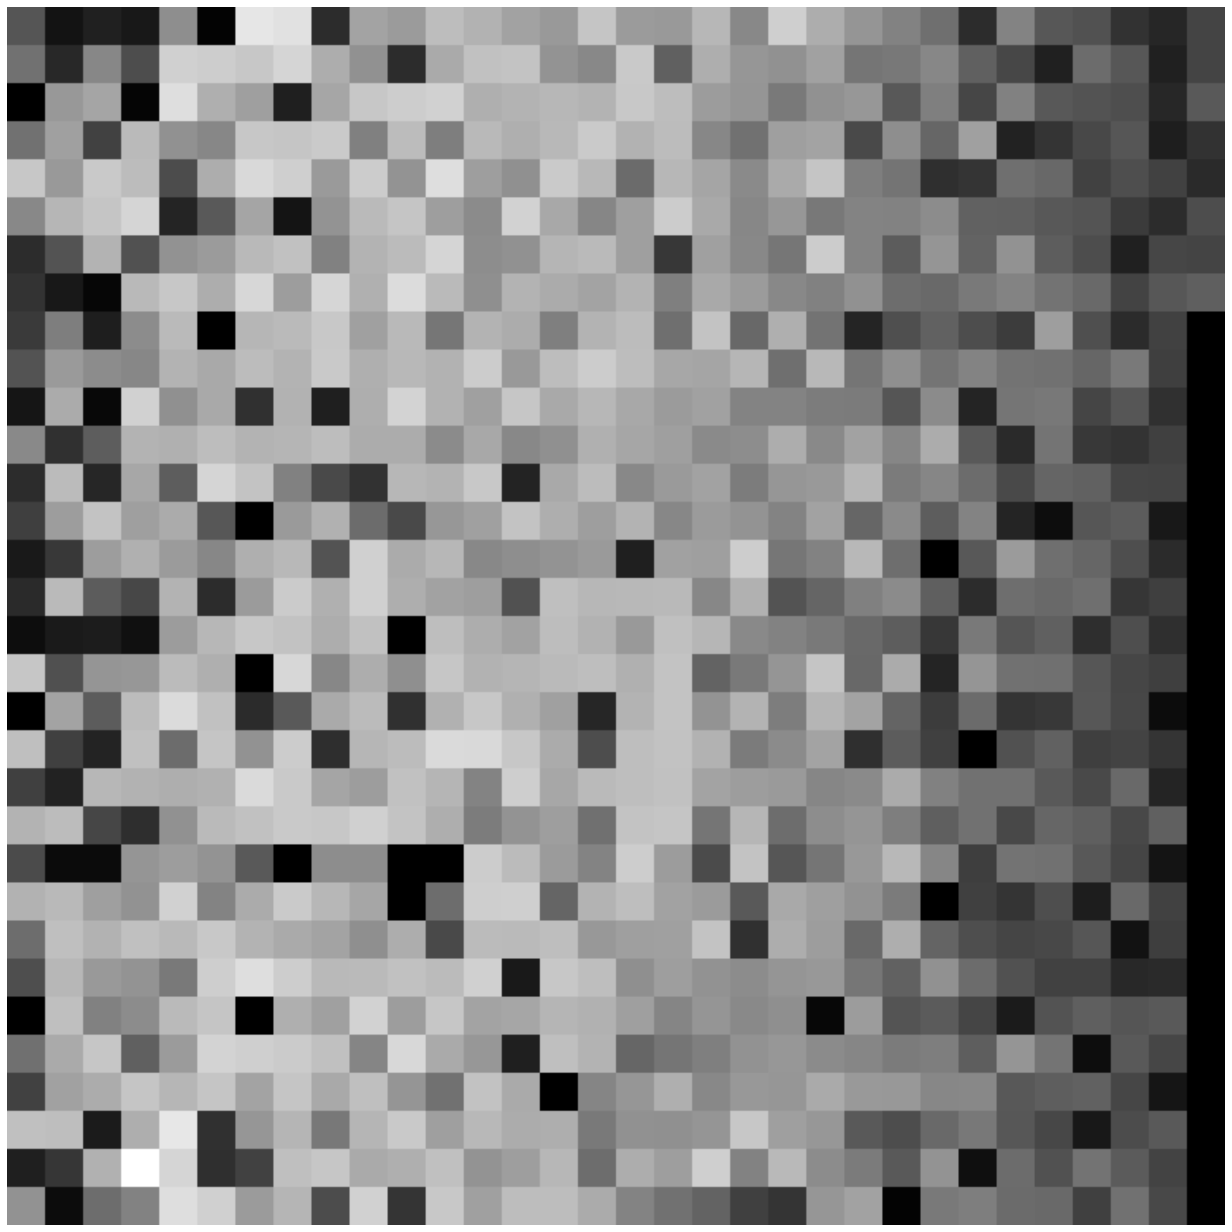

In [ ]:
display_images(vdregions)

# Partie 3 : BoW

In [ ]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])
    for sift in sifts:
        dist = np.linalg.norm(vdict-sift,2,axis=1)
        feats[np.argmin(dist)] += 1
    #normalisation
    feats /= np.linalg.norm(feats,2)
    return feats

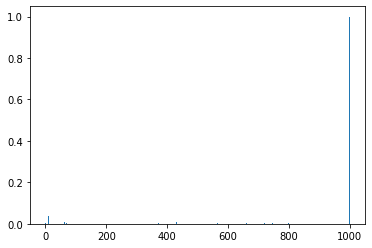

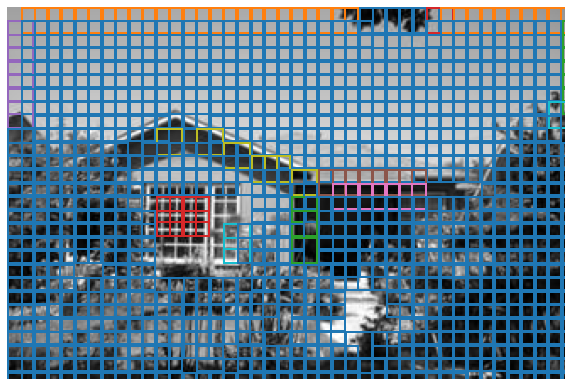

(9, 16, 16)


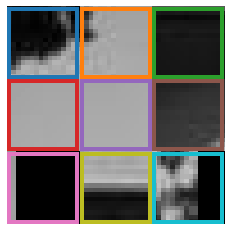

In [ ]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)

feats = compute_feats(vdict, sift)
display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here